In [1]:
import pmlb

from cleanlab_runner import ClassificationEvaluator, RegressionEvaluator, IssueHandler

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

/home/mjoudy/miniconda3/envs/galaxy-cleanlab/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
classification_datasets = {
    "iris": pmlb.fetch_data('iris'),
    "wine": pmlb.fetch_data('wine_recognition'),
    "breast_cancer": pmlb.fetch_data('breast_cancer'),
    "spambase": pmlb.fetch_data('spambase'),
    "adult": pmlb.fetch_data('adult'),
    "connect_4": pmlb.fetch_data('connect_4'),
    #"cars": pmlb.fetch_data('cars')
}

regression_datasets = {
    "cpu": pmlb.fetch_data('197_cpu_act'),
    "esl": pmlb.fetch_data('1027_ESL'),
    "satellite": pmlb.fetch_data('294_satellite_image'),
    "mv": pmlb.fetch_data('344_mv')
}

In [3]:
classification_models = {
    'logistic_regression': LogisticRegression(max_iter=1000),
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'decision_tree': DecisionTreeClassifier(random_state=42),
}

regression_models = {
    'linear_regression': LinearRegression(),
    #'ridge_regression': Ridge(alpha=1.0),
    'lasso_regression': Lasso(alpha=0.1),
    'random_forest': RandomForestRegressor(n_estimators=100, random_state=42),
    #'svr': SVR(kernel='rbf')
}

In [4]:
ds_1 = classification_datasets['connect_4']

baseline_eval = ClassificationEvaluator(
    name="cls_test",
    dataset=ds_1,
    model=classification_models['random_forest'],
    task="classification"
)
baseline_eval.train()
baseline_eval.evaluate()

[Classification] cls_test - RandomForestClassifier: Accuracy=0.8120 | CV=0.5626±0.0730


In [5]:
handler = IssueHandler(dataset=ds_1, task="classification")
_, issues = handler.report_issues()



Finding label issues ...
Finding outlier issues ...
Error in outlier: 'memoryview' object has no attribute 'reshape'
Finding near_duplicate issues ...
Error in near_duplicate: 'memoryview' object has no attribute 'reshape'
Finding non_iid issues ...
Error in non_iid: 'numpy.ndarray' object has no attribute 'indices'
Finding class_imbalance issues ...
Finding underperforming_group issues ...
Error in underperforming_group: Precomputed matrix must be square. Input is a 67557x10 matrix.
Failed to check for these issue types: [OutlierIssueManager, NearDuplicateIssueManager, NonIIDIssueManager, UnderperformingGroupIssueManager]

Audit complete. 5445 issues found in the dataset.
        issue_type     score  num_issues
0            label  0.957221        5445
1  class_imbalance  0.095460           0


In [6]:
issues

,is_label_issue,label_score,is_class_imbalance_issue,class_imbalance_score
0,False,0.643077,False,1.00000
1,False,0.628642,False,1.00000
2,False,0.648204,False,1.00000
3,False,0.816819,False,1.00000
4,False,0.926714,False,1.00000
...,...,...,...,...
67552,False,0.388399,False,1.00000
67553,False,0.203662,False,0.09546
67554,False,0.534462,False,1.00000
67555,False,0.276822,False,0.09546


In [7]:
df_cleaned = handler.clean_selected_issues(
    method='remove',
    label_issues=True,
    outliers=True,
    near_duplicates=True,
    non_iid=True
)

cleaned_eval = ClassificationEvaluator(
    name="credit_g_cleaned",
    dataset=df_cleaned,
    model=classification_models['random_forest'],
    task="classification"
)
cleaned_eval.train()
cleaned_eval.evaluate()

[Classification] credit_g_cleaned - RandomForestClassifier: Accuracy=0.8686 | CV=0.5998±0.0770


In [8]:
import pandas as pd
import os

log_path = "training_log.csv"

for ds_name, ds in classification_datasets.items():
    for model_name, model in classification_models.items():
        print(f"Evaluating {model_name} on {ds_name}")

        # 1. Original dataset evaluation
        evaluator_orig = ClassificationEvaluator(ds_name, ds.copy(), model, task='classification')
        evaluator_orig.train()
        evaluator_orig.evaluate()
        original_metric = round(evaluator_orig.metric, 4)

        # 2. Cleaned dataset evaluation
        handler = IssueHandler(ds.copy(), task='classification')
        original_df, issues = handler.report_issues()
        cleaned = handler.clean_selected_issues(method='remove')

        evaluator_clean = ClassificationEvaluator(ds_name, cleaned, model, task='classification')
        evaluator_clean.train()
        evaluator_clean.evaluate()

        # 3. Count sizes and issues
        cleaned_dataset_size = len(cleaned)
        num_issues = issues.any(axis=1).sum()  # rows with at least one issue

        # 4. Log results
        evaluator_clean.log_results(
            path=log_path,
            cleaned_dataset_size=cleaned_dataset_size,
            num_issues=num_issues
        )

        # 5. Compute improvement
        cleaned_metric = round(evaluator_clean.metric, 4)
        improvement = round(cleaned_metric - original_metric, 4)

        # 6. Update the last row in the log
        df = pd.read_csv(log_path)
        if not df.empty:
            df.loc[df.index[-1], 'original_metric'] = original_metric
            df.loc[df.index[-1], 'cleaned_metric'] = cleaned_metric
            df.loc[df.index[-1], 'improvement'] = improvement
            df.to_csv(log_path, index=False)


Evaluating logistic_regression on iris


[Classification] iris - LogisticRegression: Accuracy=1.0000 | CV=0.9667±0.0094
Finding label issues ...
Finding outlier issues ...
Error in outlier: 'memoryview' object has no attribute 'reshape'
Finding near_duplicate issues ...
Error in near_duplicate: 'memoryview' object has no attribute 'reshape'
Finding non_iid issues ...
Error in non_iid: 'numpy.ndarray' object has no attribute 'indices'
Finding class_imbalance issues ...
Finding underperforming_group issues ...
Error in underperforming_group: Precomputed matrix must be square. Input is a 150x10 matrix.
Failed to check for these issue types: [OutlierIssueManager, NearDuplicateIssueManager, NonIIDIssueManager, UnderperformingGroupIssueManager]

Audit complete. 8 issues found in the dataset.
        issue_type     score  num_issues
0            label  0.946667           8
1  class_imbalance  0.333333           0
[Classification] iris - LogisticRegression: Accuracy=1.0000 | CV=1.0000±0.0000
Evaluating random_forest on iris
[Classifi

In [9]:
import pandas as pd

log_path = "training_log.csv"

for ds_name, ds in regression_datasets.items():
    for model_name, model in regression_models.items():
        print(f"Evaluating {model_name} on {ds_name}")

        # 1. Original dataset evaluation
        evaluator_orig = RegressionEvaluator(ds_name, ds.copy(), model, task='regression')
        evaluator_orig.train()
        evaluator_orig.evaluate()
        original_metric = round(evaluator_orig.metric, 4)

        # 2. Cleaned dataset evaluation
        handler = IssueHandler(ds.copy(), task='regression')
        original_df, issues = handler.report_issues()
        cleaned = handler.clean_selected_issues(method='remove')

        evaluator_clean = RegressionEvaluator(ds_name, cleaned, model, task='regression')
        evaluator_clean.train()
        evaluator_clean.evaluate()

        # 3. Count sizes and issues
        cleaned_dataset_size = len(cleaned)
        num_issues = issues['is_label_issue'].sum() if 'is_label_issue' in issues.columns else 0

        # 4. Log results
        evaluator_clean.log_results(
            path=log_path,
            cleaned_dataset_size=cleaned_dataset_size,
            num_issues=num_issues
        )

        # 5. Compute improvement
        cleaned_metric = round(evaluator_clean.metric, 4)
        improvement = round(cleaned_metric - original_metric, 4)

        # 6. Update the last row in the log
        df = pd.read_csv(log_path)
        if not df.empty:
            df.loc[df.index[-1], 'original_metric'] = original_metric
            df.loc[df.index[-1], 'cleaned_metric'] = cleaned_metric
            df.loc[df.index[-1], 'improvement'] = improvement
            df.to_csv(log_path, index=False)


Evaluating linear_regression on cpu
[Regression] cpu - LinearRegression: RMSE=8.8765 | CV=9.7359±2.6888
[Regression] cpu - LinearRegression: RMSE=0.9780 | CV=0.9671±0.2731
Evaluating lasso_regression on cpu
[Regression] cpu - Lasso: RMSE=8.8762 | CV=9.7375±2.6745
[Regression] cpu - Lasso: RMSE=0.9869 | CV=0.9911±0.3120
Evaluating random_forest on cpu
[Regression] cpu - RandomForestRegressor: RMSE=2.4607 | CV=2.4984±0.5599
[Regression] cpu - RandomForestRegressor: RMSE=3.1241 | CV=2.4444±1.4733
Evaluating linear_regression on esl
[Regression] esl - LinearRegression: RMSE=0.5269 | CV=0.5333±0.0461
[Regression] esl - LinearRegression: RMSE=0.5040 | CV=0.4975±0.1712
Evaluating lasso_regression on esl
[Regression] esl - Lasso: RMSE=0.5442 | CV=0.5463±0.1302
[Regression] esl - Lasso: RMSE=0.5259 | CV=0.5106±0.2087
Evaluating random_forest on esl
[Regression] esl - RandomForestRegressor: RMSE=0.6371 | CV=0.5832±0.2065
[Regression] esl - RandomForestRegressor: RMSE=0.5194 | CV=0.5471±0.2111
Ev

In [ ]:
training_log = pd.read_csv(log_path)

training_log


,dataset,dataset_size,cleaned_dataset_size,num_issues,task,model,metric,cv_mean,cv_std,train_time,original_metric,cleaned_metric,improvement
0,iris,142,142,150,classification,LogisticRegression,1.000000,1.000000,0.000000,0.011605,1.0000,1.0000,0.0000
1,iris,142,142,150,classification,RandomForestClassifier,1.000000,1.000000,0.000000,0.118069,1.0000,1.0000,0.0000
2,iris,142,142,150,classification,KNeighborsClassifier,1.000000,1.000000,0.000000,0.001927,1.0000,1.0000,0.0000
3,iris,142,142,150,classification,DecisionTreeClassifier,1.000000,1.000000,0.000000,0.002024,1.0000,1.0000,0.0000
4,wine,176,176,178,classification,LogisticRegression,0.944444,0.949153,0.049897,0.151367,0.9722,0.9444,-0.0278
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,satellite,5235,5235,1200,regression,Lasso,0.857518,0.859253,0.204688,0.054707,1.2076,0.8575,-0.3501
68,satellite,5235,5235,1200,regression,RandomForestRegressor,0.416355,0.476825,0.075464,5.894356,0.6997,0.4164,-0.2833
69,mv,11884,11884,28884,regression,LinearRegression,0.785498,0.787539,0.133811,0.004542,4.4742,0.7855,-3.6887
70,mv,11884,11884,28884,regression,Lasso,0.862920,0.871663,0.145581,0.006605,4.4890,0.8629,-3.6261


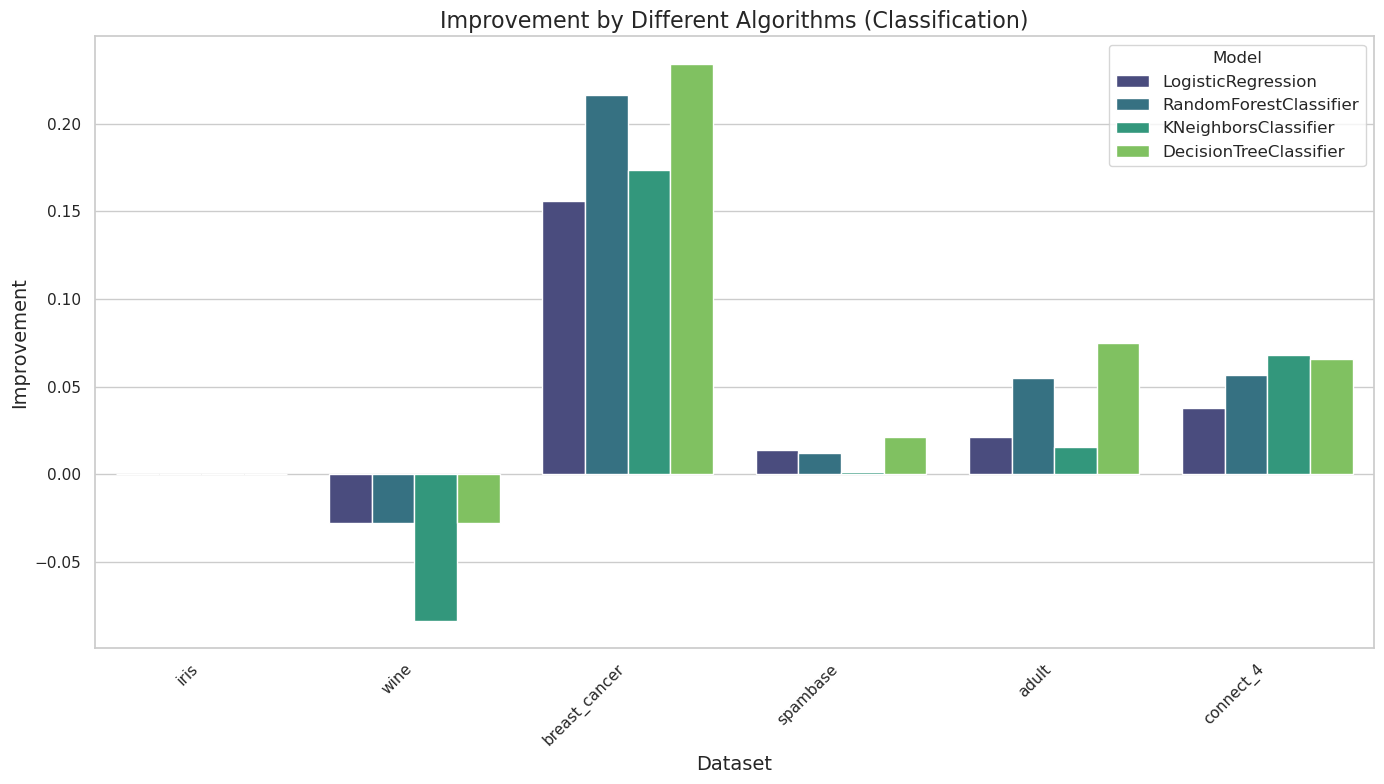

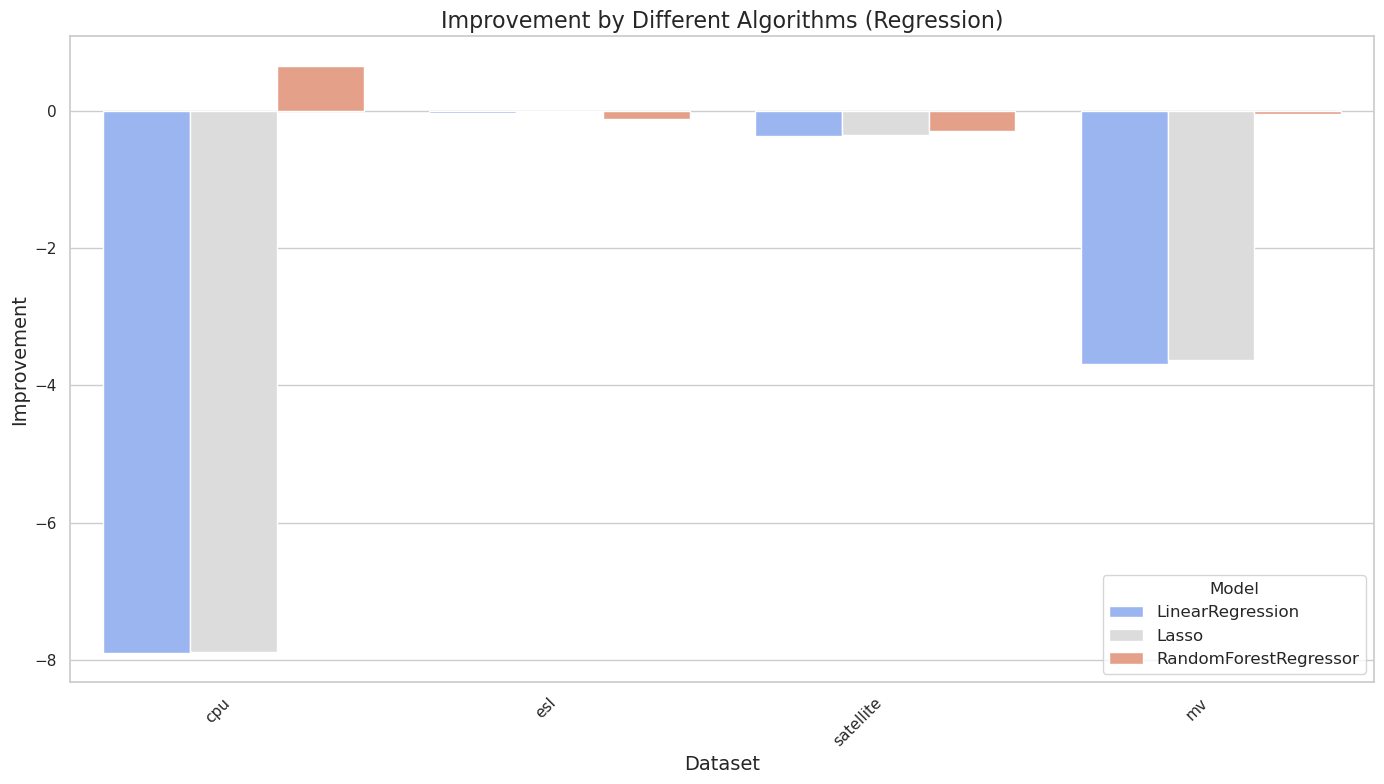

In [13]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style for the plots
sns.set(style="whitegrid")

# Separate classification and regression data
classification_data = training_log[training_log['task'] == 'classification']
regression_data = training_log[training_log['task'] == 'regression']

# Plot for classification
plt.figure(figsize=(14, 8))
sns.barplot(
    data=classification_data,
    x='dataset',
    y='improvement',
    hue='model',
    palette='viridis'
)
plt.title('Improvement by Different Algorithms (Classification)', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Improvement', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', fontsize=12)
plt.tight_layout()
plt.show()

# Plot for regression
plt.figure(figsize=(14, 8))
sns.barplot(
    data=regression_data,
    x='dataset',
    y='improvement',
    hue='model',
    palette='coolwarm'
)
plt.title('Improvement by Different Algorithms (Regression)', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Improvement', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', fontsize=12)
plt.tight_layout()
plt.show()